In [79]:
# Importa bibliotecas
from datetime import timedelta
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns  
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [80]:
# Usa pandas para ler o csv
df = pd.read_csv("D:\\Codigos\\Fatec\\lab4\\timeSeries\\base\\Weather Data.csv")
df.head()

# Dataset: https://www.kaggle.com/datasets/swatikhedekar/python-project-on-weather-dataset/
# OBS: para esse exercicio apenas o primerio mês está sendo usado

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [81]:
# Como essa será uma validação simples, usarei apenas Temp_C
df = df[['Date/Time', 'Temp_C']]
df.head()


,Date/Time,Temp_C
0,1/1/2012 0:00,-1.8
1,1/1/2012 1:00,-1.8
2,1/1/2012 2:00,-1.8
3,1/1/2012 3:00,-1.5
4,1/1/2012 4:00,-1.5


In [82]:
# ve quantidade de valores nulos, para tratamento
df.isnull().sum()


Date/Time    0
Temp_C       0
dtype: int64

In [83]:
# Preencheria colunas em branco, caso tivesse
df.interpolate(method='linear', inplace=True)


C:\Users\augus\AppData\Local\Temp\ipykernel_11568\3513534670.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [84]:
# ve o tipo do dado, para tratamento
df.dtypes


Date/Time     object
Temp_C       float64
dtype: object

In [85]:
"""
A analise temporal geralmente preve tempo (datetime) por valor numerico (float ou int), nesse caso precisamos converter
a coluna Data/Time para datetime.
"""

df['Date/Time'] = pd.to_datetime(df['Date/Time'])
print(df.dtypes)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

# caso Temp_C não fosse int ou float usariamos pandas para sua conversão também.


Date/Time    datetime64[ns]
Temp_C              float64
dtype: object
+----+---------------------+----------+
|    | Date/Time           |   Temp_C |
|----+---------------------+----------|
|  0 | 2012-01-01 00:00:00 |     -1.8 |
|  1 | 2012-01-01 01:00:00 |     -1.8 |
|  2 | 2012-01-01 02:00:00 |     -1.8 |
|  3 | 2012-01-01 03:00:00 |     -1.5 |
|  4 | 2012-01-01 04:00:00 |     -1.5 |
+----+---------------------+----------+


In [86]:
# Definimos a coluna Date/Time como indice para melhor visualização
df.set_index('Date/Time', inplace=True)
df.sort_index(inplace=True)


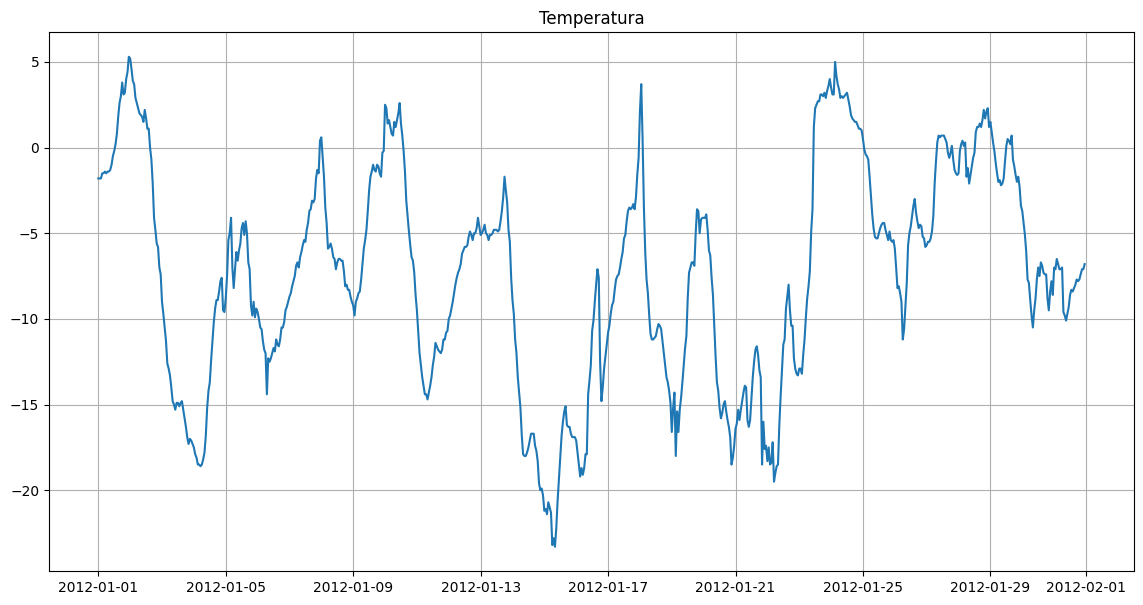

In [87]:
# Dataset completo
plt.figure(figsize=(14, 7))
plt.plot(df)
plt.title("Temperatura")
plt.grid(True)
plt.show()


In [88]:
# Definir a frequência do índice
df = df.asfreq('h')


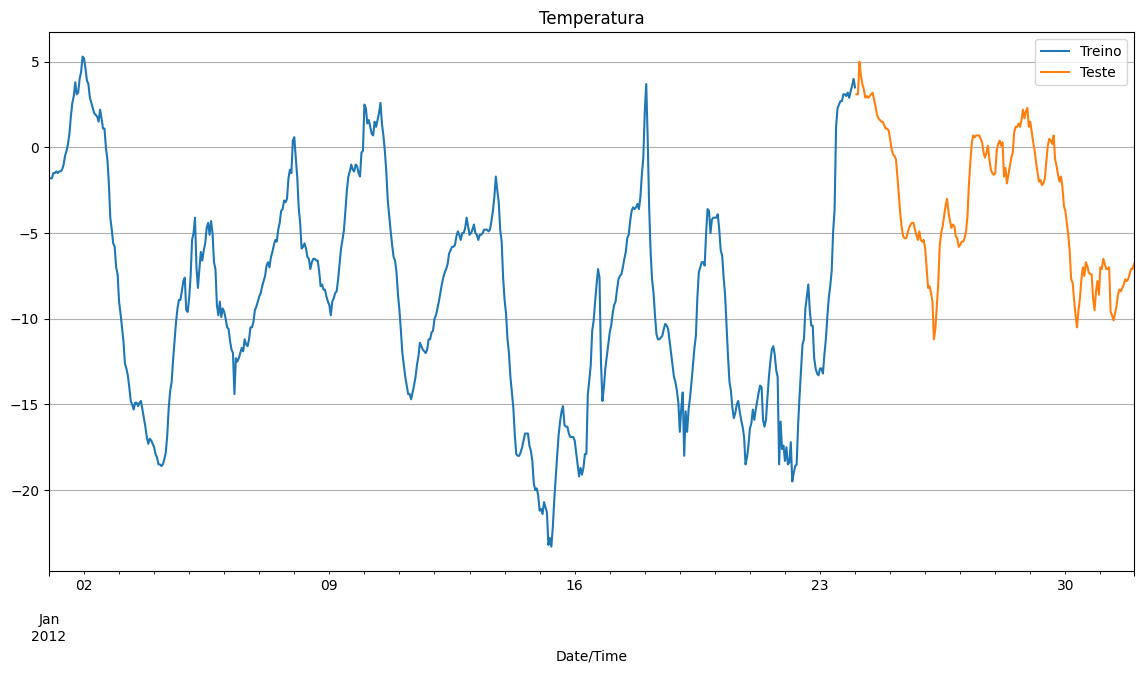

In [89]:
"""
Em nosso caso estamos visualizando temperatura de hora em hora durante janeiro 2012, vamos separar os ultimos 7 dias
para teste e o resto pro treino
"""
# Dividir os dados em treino e teste
split_date = '2012-01-24 00:00:00'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

# Visualização dos dados
fig, ax = plt.subplots(figsize=(14, 7))
data_train['Temp_C'].plot(ax=ax, label='Treino')
data_test['Temp_C'].plot(ax=ax, label='Teste')
ax.legend()
plt.title("Temperatura")
plt.grid(True)
plt.show()


In [90]:
# Calcular pesos exponenciais decrescentes com base em horas
max_date = data_train.index.max()
data_train['weight'] = np.exp((data_train.index - max_date) / timedelta(hours=1))

# Normalizar pesos para somarem 1
data_train['weight'] = data_train['weight'] / data_train['weight'].sum()


In [91]:
# Função para criar lags
def create_lags(data, lags):
    df_lags = pd.concat([data.shift(i) for i in range(1, lags + 1)], axis=1)
    df_lags.columns = [f'lag_{i}' for i in range(1, lags + 1)]
    return df_lags

# Cria lags para o conjunto de treinamento
lags = 506
train_lags = create_lags(data_train['Temp_C'], lags).dropna()
train_lags_values = train_lags.values
train_target = data_train['Temp_C'][lags:].values

# Ajustar pesos para corresponder ao tamanho dos dados de treino com lags
weights = data_train['weight'][lags:]

In [92]:
# GridSearch para ajustar hiperparâmetros do RandomForest
param_grid = {
    'n_estimators': [7, 30, 365], # n_estimators possiveis
    'max_depth': [10, 15, 20, 25, 30] # max depth possiveis
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=123), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(train_lags_values, train_target, sample_weight=weights)
best_params = grid_search.best_params_


Fitting 3 folds for each of 15 candidates, totalling 45 fits


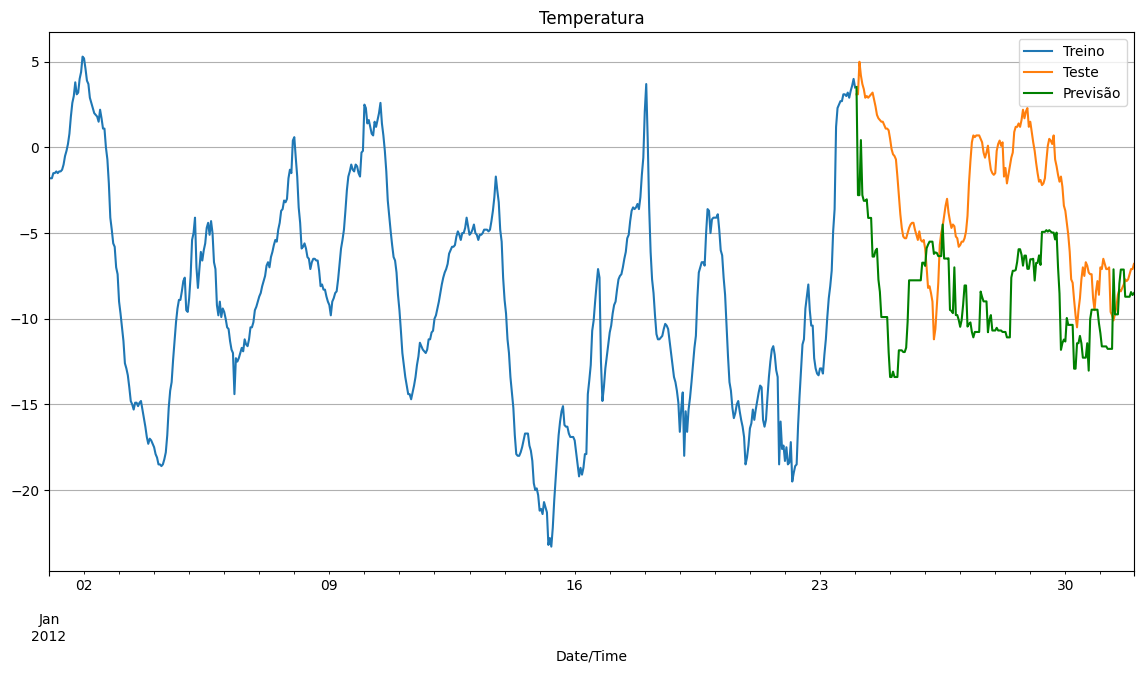

In [93]:
# Cria e treina o modelo
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(**best_params, random_state=123),
    lags=lags
)

# Ajustar o forecaster para usar o DataFrame original com índice correto
forecaster.fit(y=data_train['Temp_C'])

# Faz previsões
predictions = forecaster.predict(steps=len(data_test))
predictions.index = data_test.index

# Visualização das previsões
fig, ax = plt.subplots(figsize=(14, 7))
data_train['Temp_C'].plot(ax=ax, label='Treino')
data_test['Temp_C'].plot(ax=ax, label='Teste')
predictions.plot(ax=ax, label='Previsão', color='green')
ax.legend()
plt.title("Temperatura")
plt.grid(True)
plt.show()



In [94]:
# Calcula e exibe métricas de avaliação
mse = mean_squared_error(data_test['Temp_C'], predictions)
mae = mean_absolute_error(data_test['Temp_C'], predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 45.27705737792499
Mean Absolute Error: 5.766791323859388
